#### Week12-Extra Credict
##### Author: Wen-shan,Liu
##### Date: 05/03/2025

# **Intro of Generative Adversarial Network (GAN)**
**- How it works? </br>**

  A Generative Adversarial Network (GAN) consists of two neural networks—the Generator (G) and the Discriminator (D)—that compete in a game-theoretic setup.

  The Generator learns to create realistic-looking data (e.g., images) from random noise. One the other hand, the Discriminator tries to distinguish between real data (from the training set) and fake data (produced by the generator).

  They are trained simultaneously. The generator(G) improves by fooling the discriminator (D). The discriminator(D) improves by detecting fake data.
  

  Generative Adversarial Network (GAN) was invented by Goodfellow in 2014. In his paper[1] mention the whole adversarial training framework in GAN is following two-player minimax game with with value function V (G, D):
  
<img src="./Picture/CleanShot.jpg">


---


**- How it used?**

GANs are widely applied in areas that involve data generation, especially for tasks that require learning data distributions without labels:

  Image synthesis: e.g., human face generation (StyleGAN)[2].

  Image-to-image translation: e.g., converting summer to winter scenes or photos to paintings (CycleGAN)[3].

  Impuatation missing value: e.g., imputate medical missing value in EHR datasets (ccGAN)[4].



---


**- Any gotchas in using it?**


Training GANs is notoriously difficult and prone to several challenges:

 - Mode collapse: the generator produces limited variety, ignoring parts of the data distribution.

 - Training instability: the balance between G and D is delicate and can lead to divergence.

 - Resource-intensive: GANs require significant computational power and tuning.

 - Hyperparameter sensitivity: results can vary greatly based on architecture and optimizer settings.




---


Reference: </br>
[1] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2017). GAN(Generative Adversarial Nets). Journal of Japan Society for Fuzzy Theory and Intelligent Informatics, 29(5), 177. https://doi.org/10.3156/jsoft.29.5_177_2


[2] Karras, T., Laine, S., & Aila, T. (2019). A Style-Based generator architecture for generative adversarial networks. 2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2019.00453


[3] Zhu et al. (2017), “Unpaired Image-to-Image Translation with CycleGAN”
https://arxiv.org/abs/1703.10593

[4] Bernardini, M., Doinychko, A., Romeo, L., Frontoni, E., & Amini, M. (2023). A novel missing data imputation approach based on clinical conditional Generative Adversarial Networks applied to EHR datasets. Computers in Biology and Medicine, 163, 107188. https://doi.org/10.1016/j.compbiomed.2023.107188


In [9]:
# Example of GAN by using Pytorch
# In this example, it will demostrate how to implement GAN and generate realistic images.

#step1 : import libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# Check running device
# use cuda(gpu) or cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device is:', device)


device is: cuda


In [10]:
# Step 2: Defining Image Transformations
# To normalize and convert images into tensors before feeding them into the model.

# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), # (mean values of each colors)
                         (0.5, 0.5, 0.5)) # (std for each color channel)
])


In [11]:
# Step 3: Loading the CIFAR-10 Dataset

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset,  batch_size=64, shuffle=True)

In [12]:
# Step 4: Defining GAN Hyperparameters
# Hyperparameters
latent_dim = 100
lr = 0.0001
beta1 = 0.5  # parameters for the Adam optimizer
beta2 = 0.999 # parameters for the Adam optimize
num_epochs = 100

In [13]:

#Step 5: Building the Generator

# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8), # Takes the random noise (latent_dim) and transforms it into a higher-dimension
            nn.ReLU(),   # use non-linearity, allowing the generator to learn complex patterns.
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),  # middle layers: nn.Unflatten、nn.Upsample、nn.Conv2d、nn.BatchNorm2d
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh() # output layer
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [14]:
# Step 6: Building the Discriminator


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout2d(0.25),

    )


    def forward(self, img):
        validity = self.model(img)
        return validity

In [15]:
# Step 7: Initializing GAN Components

# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
#adversarial_loss = nn.BCELoss()
# use WGAN loss fuction to replace BCELoss()
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

Epoch [1/100]                        Batch 100/782 Discriminator Loss: 0.0032 Generator Loss: 0.0085
Epoch [1/100]                        Batch 200/782 Discriminator Loss: -0.0065 Generator Loss: 0.0277
Epoch [1/100]                        Batch 300/782 Discriminator Loss: 0.0023 Generator Loss: 0.0038
Epoch [1/100]                        Batch 400/782 Discriminator Loss: -0.0041 Generator Loss: 0.0013
Epoch [1/100]                        Batch 500/782 Discriminator Loss: -0.0096 Generator Loss: 0.0111
Epoch [1/100]                        Batch 600/782 Discriminator Loss: 0.0014 Generator Loss: -0.0021
Epoch [1/100]                        Batch 700/782 Discriminator Loss: -0.0130 Generator Loss: -0.0000
Epoch [2/100]                        Batch 100/782 Discriminator Loss: -0.0018 Generator Loss: -0.0044
Epoch [2/100]                        Batch 200/782 Discriminator Loss: -0.0006 Generator Loss: 0.0069
Epoch [2/100]                        Batch 300/782 Discriminator Loss: -0.0037 Gen

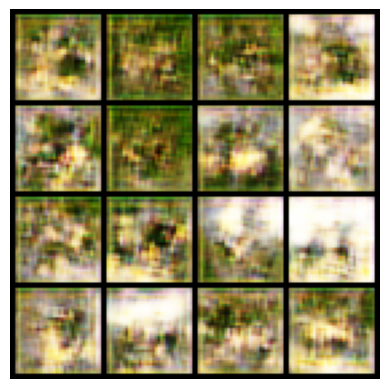

Epoch [11/100]                        Batch 100/782 Discriminator Loss: -0.0055 Generator Loss: 0.0195
Epoch [11/100]                        Batch 200/782 Discriminator Loss: -0.0031 Generator Loss: 0.0219
Epoch [11/100]                        Batch 300/782 Discriminator Loss: 0.0001 Generator Loss: 0.0002
Epoch [11/100]                        Batch 400/782 Discriminator Loss: -0.0027 Generator Loss: 0.0076
Epoch [11/100]                        Batch 500/782 Discriminator Loss: -0.0068 Generator Loss: 0.0032
Epoch [11/100]                        Batch 600/782 Discriminator Loss: 0.0110 Generator Loss: -0.0117
Epoch [11/100]                        Batch 700/782 Discriminator Loss: -0.0031 Generator Loss: 0.0063
Epoch [12/100]                        Batch 100/782 Discriminator Loss: 0.0095 Generator Loss: 0.0254
Epoch [12/100]                        Batch 200/782 Discriminator Loss: 0.0050 Generator Loss: 0.0099
Epoch [12/100]                        Batch 300/782 Discriminator Loss: 0.01

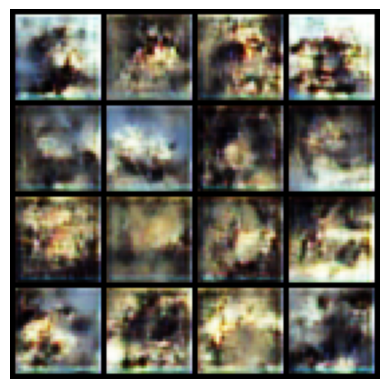

Epoch [21/100]                        Batch 100/782 Discriminator Loss: -0.0028 Generator Loss: -0.0007
Epoch [21/100]                        Batch 200/782 Discriminator Loss: -0.0121 Generator Loss: 0.0011
Epoch [21/100]                        Batch 300/782 Discriminator Loss: -0.0022 Generator Loss: -0.0109
Epoch [21/100]                        Batch 400/782 Discriminator Loss: -0.0034 Generator Loss: 0.0236
Epoch [21/100]                        Batch 500/782 Discriminator Loss: 0.0034 Generator Loss: 0.0095
Epoch [21/100]                        Batch 600/782 Discriminator Loss: 0.0107 Generator Loss: -0.0014
Epoch [21/100]                        Batch 700/782 Discriminator Loss: -0.0044 Generator Loss: 0.0041
Epoch [22/100]                        Batch 100/782 Discriminator Loss: 0.0014 Generator Loss: 0.0050
Epoch [22/100]                        Batch 200/782 Discriminator Loss: -0.0076 Generator Loss: 0.0265
Epoch [22/100]                        Batch 300/782 Discriminator Loss: -

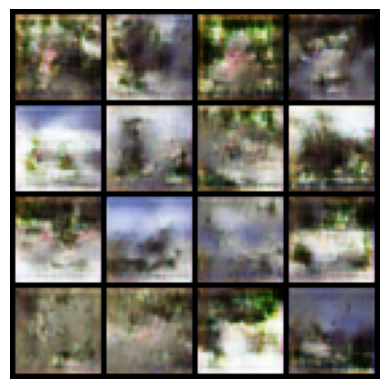

Epoch [31/100]                        Batch 100/782 Discriminator Loss: -0.0175 Generator Loss: -0.0165
Epoch [31/100]                        Batch 200/782 Discriminator Loss: 0.0131 Generator Loss: -0.0481
Epoch [31/100]                        Batch 300/782 Discriminator Loss: 0.0094 Generator Loss: -0.0175
Epoch [31/100]                        Batch 400/782 Discriminator Loss: -0.0016 Generator Loss: 0.0042
Epoch [31/100]                        Batch 500/782 Discriminator Loss: 0.0009 Generator Loss: -0.0021
Epoch [31/100]                        Batch 600/782 Discriminator Loss: 0.0018 Generator Loss: 0.0001
Epoch [31/100]                        Batch 700/782 Discriminator Loss: -0.0056 Generator Loss: -0.0073
Epoch [32/100]                        Batch 100/782 Discriminator Loss: 0.0010 Generator Loss: 0.0049
Epoch [32/100]                        Batch 200/782 Discriminator Loss: 0.0022 Generator Loss: -0.0075
Epoch [32/100]                        Batch 300/782 Discriminator Loss: -

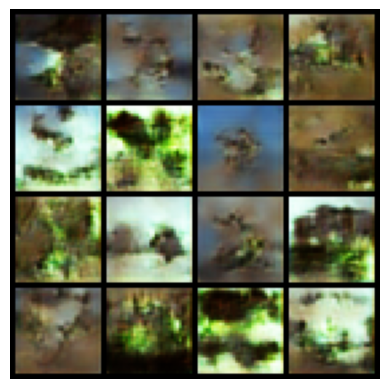

Epoch [41/100]                        Batch 100/782 Discriminator Loss: -0.0029 Generator Loss: 0.0026
Epoch [41/100]                        Batch 200/782 Discriminator Loss: -0.0058 Generator Loss: -0.0004
Epoch [41/100]                        Batch 300/782 Discriminator Loss: 0.0024 Generator Loss: -0.0013
Epoch [41/100]                        Batch 400/782 Discriminator Loss: -0.0015 Generator Loss: -0.0031
Epoch [41/100]                        Batch 500/782 Discriminator Loss: 0.0003 Generator Loss: 0.0065
Epoch [41/100]                        Batch 600/782 Discriminator Loss: 0.0001 Generator Loss: 0.0045
Epoch [41/100]                        Batch 700/782 Discriminator Loss: -0.0003 Generator Loss: -0.0018
Epoch [42/100]                        Batch 100/782 Discriminator Loss: 0.0024 Generator Loss: -0.0038
Epoch [42/100]                        Batch 200/782 Discriminator Loss: 0.0008 Generator Loss: -0.0042
Epoch [42/100]                        Batch 300/782 Discriminator Loss: 

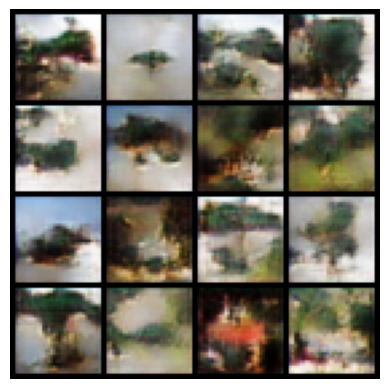

Epoch [51/100]                        Batch 100/782 Discriminator Loss: 0.0036 Generator Loss: 0.0066
Epoch [51/100]                        Batch 200/782 Discriminator Loss: -0.0031 Generator Loss: -0.0002
Epoch [51/100]                        Batch 300/782 Discriminator Loss: -0.0100 Generator Loss: -0.0171
Epoch [51/100]                        Batch 400/782 Discriminator Loss: -0.0001 Generator Loss: 0.0080
Epoch [51/100]                        Batch 500/782 Discriminator Loss: 0.0004 Generator Loss: 0.0066
Epoch [51/100]                        Batch 600/782 Discriminator Loss: -0.0065 Generator Loss: -0.0040
Epoch [51/100]                        Batch 700/782 Discriminator Loss: 0.0015 Generator Loss: -0.0006
Epoch [52/100]                        Batch 100/782 Discriminator Loss: -0.0049 Generator Loss: 0.0001
Epoch [52/100]                        Batch 200/782 Discriminator Loss: 0.0032 Generator Loss: 0.0063
Epoch [52/100]                        Batch 300/782 Discriminator Loss: -

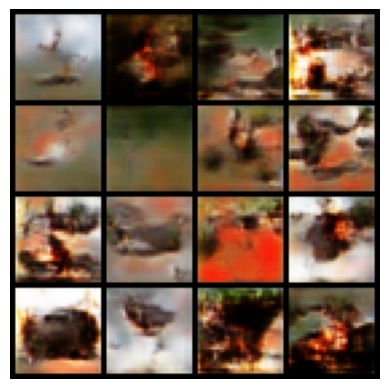

Epoch [61/100]                        Batch 100/782 Discriminator Loss: 0.0157 Generator Loss: 0.0196
Epoch [61/100]                        Batch 200/782 Discriminator Loss: -0.0059 Generator Loss: 0.0131
Epoch [61/100]                        Batch 300/782 Discriminator Loss: 0.0061 Generator Loss: 0.0002
Epoch [61/100]                        Batch 400/782 Discriminator Loss: -0.0027 Generator Loss: 0.0084
Epoch [61/100]                        Batch 500/782 Discriminator Loss: -0.0013 Generator Loss: 0.0317
Epoch [61/100]                        Batch 600/782 Discriminator Loss: 0.0001 Generator Loss: 0.0233
Epoch [61/100]                        Batch 700/782 Discriminator Loss: 0.0026 Generator Loss: 0.0018
Epoch [62/100]                        Batch 100/782 Discriminator Loss: 0.0009 Generator Loss: 0.0079
Epoch [62/100]                        Batch 200/782 Discriminator Loss: 0.0071 Generator Loss: 0.0039
Epoch [62/100]                        Batch 300/782 Discriminator Loss: 0.0052 

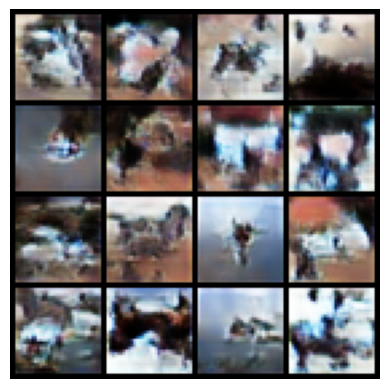

Epoch [71/100]                        Batch 100/782 Discriminator Loss: 0.0067 Generator Loss: -0.0421
Epoch [71/100]                        Batch 200/782 Discriminator Loss: -0.0099 Generator Loss: -0.0209
Epoch [71/100]                        Batch 300/782 Discriminator Loss: 0.0125 Generator Loss: 0.0087
Epoch [71/100]                        Batch 400/782 Discriminator Loss: -0.0012 Generator Loss: 0.0062
Epoch [71/100]                        Batch 500/782 Discriminator Loss: -0.0038 Generator Loss: 0.0199
Epoch [71/100]                        Batch 600/782 Discriminator Loss: 0.0052 Generator Loss: -0.0404
Epoch [71/100]                        Batch 700/782 Discriminator Loss: -0.0019 Generator Loss: -0.0020
Epoch [72/100]                        Batch 100/782 Discriminator Loss: -0.0071 Generator Loss: 0.0129
Epoch [72/100]                        Batch 200/782 Discriminator Loss: -0.0094 Generator Loss: 0.0062
Epoch [72/100]                        Batch 300/782 Discriminator Loss: 

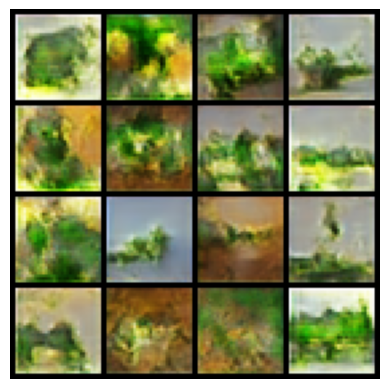

Epoch [81/100]                        Batch 100/782 Discriminator Loss: 0.0151 Generator Loss: -0.0298
Epoch [81/100]                        Batch 200/782 Discriminator Loss: -0.0109 Generator Loss: 0.0210
Epoch [81/100]                        Batch 300/782 Discriminator Loss: -0.0211 Generator Loss: -0.0593
Epoch [81/100]                        Batch 400/782 Discriminator Loss: 0.0021 Generator Loss: 0.0116
Epoch [81/100]                        Batch 500/782 Discriminator Loss: 0.0094 Generator Loss: 0.0327
Epoch [81/100]                        Batch 600/782 Discriminator Loss: 0.0035 Generator Loss: -0.0202
Epoch [81/100]                        Batch 700/782 Discriminator Loss: -0.0227 Generator Loss: -0.0451
Epoch [82/100]                        Batch 100/782 Discriminator Loss: -0.0192 Generator Loss: 0.0528
Epoch [82/100]                        Batch 200/782 Discriminator Loss: 0.0140 Generator Loss: -0.0109
Epoch [82/100]                        Batch 300/782 Discriminator Loss: -

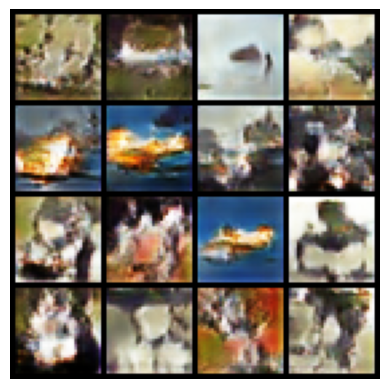

Epoch [91/100]                        Batch 100/782 Discriminator Loss: -0.0036 Generator Loss: 0.0048
Epoch [91/100]                        Batch 200/782 Discriminator Loss: -0.0118 Generator Loss: 0.0203
Epoch [91/100]                        Batch 300/782 Discriminator Loss: -0.0157 Generator Loss: 0.0069
Epoch [91/100]                        Batch 400/782 Discriminator Loss: -0.0053 Generator Loss: 0.0095
Epoch [91/100]                        Batch 500/782 Discriminator Loss: 0.0316 Generator Loss: -0.0095
Epoch [91/100]                        Batch 600/782 Discriminator Loss: 0.0018 Generator Loss: 0.0190
Epoch [91/100]                        Batch 700/782 Discriminator Loss: -0.0125 Generator Loss: -0.0114
Epoch [92/100]                        Batch 100/782 Discriminator Loss: 0.0054 Generator Loss: -0.0428
Epoch [92/100]                        Batch 200/782 Discriminator Loss: -0.0090 Generator Loss: 0.0235
Epoch [92/100]                        Batch 300/782 Discriminator Loss: 0

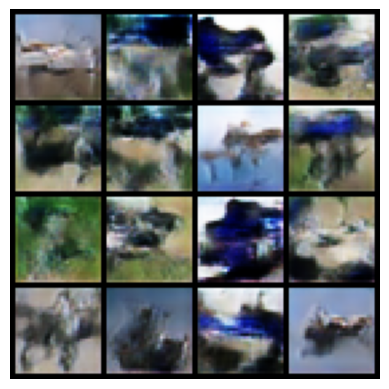

In [16]:
# Step 8: Training the GAN

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device)
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability
        # to classify real and fake images
        real_loss = -torch.mean(discriminator(real_images)) # for real images
        fake_loss = torch.mean(discriminator(fake_images.detach()))  # for fake images
        d_loss = real_loss + fake_loss  # Discriminator total loss


        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        #g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss = -torch.mean(discriminator(gen_images))  # Generator loss
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()